# Getting Started

This section gives an overview over parsing, simulating and filtering models using **pydsge**. It also explains how to load and process data from an estimation.

In [1]:
# only necessary if you run this in a jupyter notebook
%matplotlib nbagg

# to supress nasty warnings:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Parsing & simulating

Let us first import the base class and the example model:

In [2]:
from pydsge import DSGE, example
yaml_file, data_file = example

The `example` here is nothing than a tuple containing the paths to two files. The first file to the example model file (as a string):


In [3]:
print(yaml_file)

/usr/lib/python3.8/site-packages/pydsge/dfi.yaml


You can use your text editor of choice (which I hope is not Notepad) to open this file and have a look. It contains useful annotations and comments.

### Parsing ``*.mod``-files

So lets parse this thing:

In [4]:
mod = DSGE.read(yaml_file)

Of course, if you would want to parse your own ``*.yaml`` model, you could easily do that by:

In [5]:
#yaml_path = "/full/path/to/your/model.yaml"
#mod = DSGE.read(yaml_path)

But, lets for now assume you are working with ``dfi.yaml``.

The ``mod`` object is now an instance of the `DSGE` class. 
Lets load the calibrated parameters from the file (they are loaded by default anyways, but for educative purposes...) and instantize the transition function:

In [6]:
par = mod.set_par('calib')
mod.get_sys(par, reduce_sys=False, verbose=True)

[get_sys:]     Creation of system matrices finished in 0.002s.
[preprocess:]  Preproceccing finished within 0.007s.


You should have a look at the functions `set_par` and `get_par` if you want to experiment with the model. 

The ``DSGE``-instance has many attributes that concentrate information and functions of the model. They are all listed in the [module documentation](https://pydsge.readthedocs.io/en/latest/modules.html#).

### Simulate IRFs

Let us use this to simulate a series of impulse responses:

In [7]:
shock_list = ('e_u', 5, 1) # (name, size, period)
X1, (L1, K1) = mod.irfs(shock_list, verbose=True)

[irfs:]         simulation took  0.0079  seconds.


Nice. For details see the ``irfs`` function. Lets plot it using the ``pplot`` plot function from the ``grgrlib`` library:

<IPython.core.display.Javascript object>


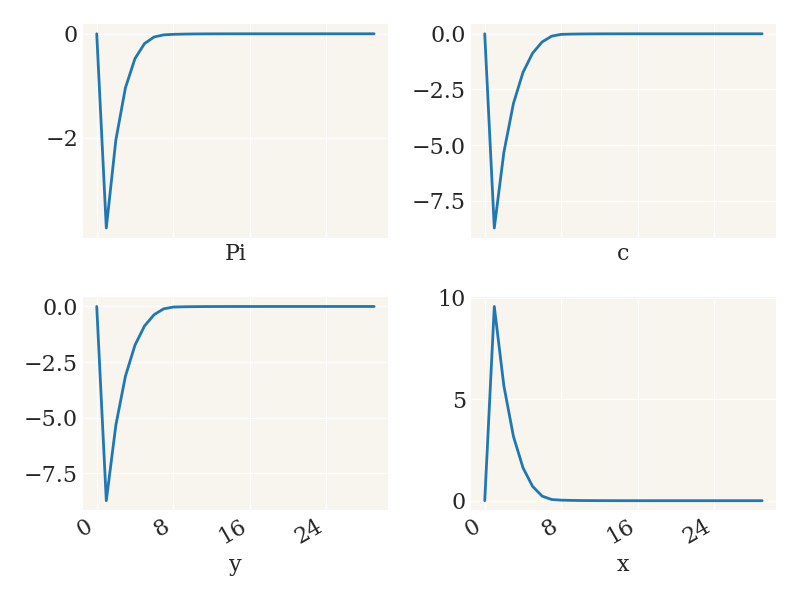

<IPython.core.display.Javascript object>


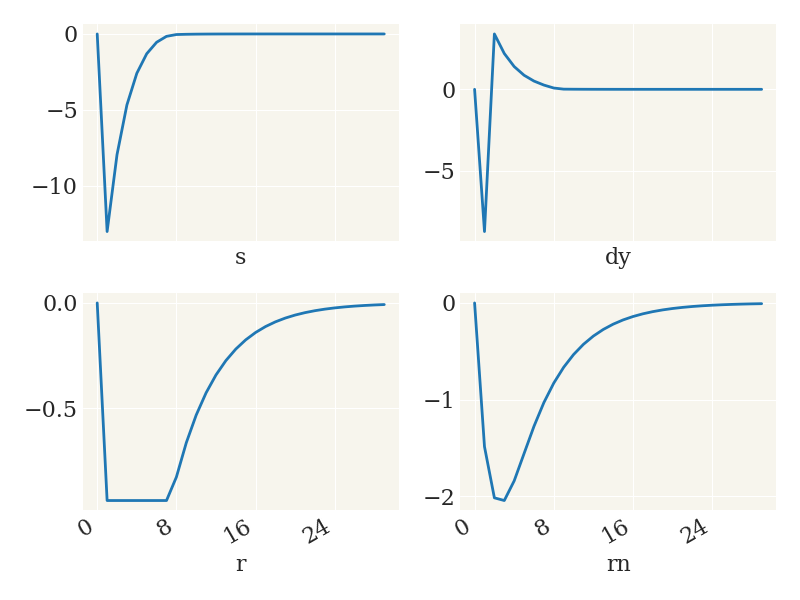

<IPython.core.display.Javascript object>


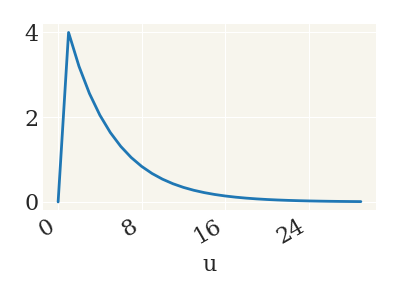

In [8]:
from grgrlib import pplot
figs, axs = pplot(X1)

Btw, the ``L1, K1`` arrays contain the series of expected durations to/at the ZLB.

### Sample from prior

Now lets assume that you have specified priors and wanted to know how flexible your model is in terms of impulse responses. The ``get_par`` function also allows sampling from the prior:

In [9]:
par0 = mod.get_par('prior', nsample=50, verbose=True)

  0%|          | 0/50 [00:00<?, ?it/s]

Adding parameters to the prior distribution...
  parameter theta as beta (0.5, 0.1). Init @ 0.7813, with bounds (0.2, 0.95)...
  parameter sigma as normal (1.5, 0.375). Init @ 1.2312, with bounds (0.25, 3)...
  parameter phi_pi as normal (1.5, 0.25). Init @ 1.7985, with bounds (1.0, 3)...
  parameter phi_y as normal (0.125, 0.05). Init @ 0.0893, with bounds (0.001, 0.5)...
  parameter rho_u as beta (0.5, 0.2). Init @ 0.7, with bounds (0.01, 0.9999)...
  parameter rho_r as beta (0.5, 0.2). Init @ 0.7, with bounds (0.01, 0.9999)...
  parameter rho_z as beta (0.5, 0.2). Init @ 0.7, with bounds (0.01, 0.9999)...
  parameter rho as beta (0.75, 0.1). Init @ 0.8, with bounds (0.5, 0.975)...
  parameter sig_u as inv_gamma_dynare (0.1, 2). Init @ 0.5, with bounds (0.025, 5)...
  parameter sig_r as inv_gamma_dynare (0.1, 2). Init @ 0.5, with bounds (0.01, 3)...
  parameter sig_z as inv_gamma_dynare (0.1, 2). Init @ 0.5, with bounds (0.01, 3)...


100%|██████████| 50/50 [00:09<00:00,  5.51it/s]

[prior_sample:] sampling done. 26.00% of the prior are either indetermined or explosive.


In [10]:
print(par0.shape)

(50, 11)


`par0` is an array with 50 samples of the 10-dimensional parameter vector. 
If you allow for ``verbose=True`` (which is the default) the function will also tell you how much of your prior is not implicitely trunkated by indetermined or explosive regions. 

Lets feed these parameters ``par0`` into our ``irfs()`` and plot it:

In [11]:
X1, (L1, K1) = mod.irfs(shock_list, par0, verbose=True)
#figs, axs = pplot(X1, labels=mod.vv)

[irfs:]         no rational expectations solution found at least once.
[irfs:]         simulation took  0.51016  seconds.


This gives you an idea on how tight your priors are. 

## Filtering & smoothing


This section treats how to load data, and do Bayesian filtering given a DSGE model.

### Load data


We have just seen how to parse the model. Parsing the data is likewise quite easy. It however assumes that you managed to put your data into pandas' ``DataFrame`` format. pandas knows many ways of loading your data file into a ``DataFrame``, see for example [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) on how to load a common ``*.csv`` file. 

Luckily I already prepared an example data file that is already well structured:

In [12]:
yaml_file, data_file = example
print(data_file)

/usr/lib/python3.8/site-packages/pydsge/tsdata.csv


Again, this is just the path to a file that you can open and explore. I constructed the file such that I can already load the column ``data`` as a ``DateTimeIndex``, which makes things easier:

In [13]:
import pandas as pd

df = pd.read_csv(data_file, parse_dates=['date'], index_col=['date'])
df.index.freq = 'Q' # let pandas know that this is quartely data

print(df)

                GDP     Infl   FFR
date                              
1995-03-31  0.16884  0.60269  1.45
1995-06-30  0.13066  0.44765  1.51
1995-09-30  0.64258  0.42713  1.45
1995-12-31  0.45008  0.47539  1.43
1996-03-31  0.47113  0.50984  1.34
...             ...      ...   ...
2017-03-31  0.41475  0.49969  0.18
2017-06-30  0.54594  0.25245  0.24
2017-09-30  0.54391  0.51972  0.29
2017-12-31  0.48458  0.57830  0.30
2018-03-31  0.15170  0.48097  0.36

[93 rows x 3 columns]


Now you should give you an idea of how the data looks like. The frame contains the time series of US output growth, inflation, and the FFR from 1995Q1 to 2018Q1.

In [14]:
mod.load_data(df)

,GDP,Infl,FFR
date,,,
1995-03-31,0.16884,0.60269,1.45
1995-06-30,0.13066,0.44765,1.51
1995-09-30,0.64258,0.42713,1.45
1995-12-31,0.45008,0.47539,1.43
1996-03-31,0.47113,0.50984,1.34
...,...,...,...
2017-03-31,0.41475,0.49969,0.18
2017-06-30,0.54594,0.25245,0.24
2017-09-30,0.54391,0.51972,0.29


This automatically selects the obsevables you defined in the ``*.yaml`` and puts them in the ``mod.data`` object. Note that it will complain if it can't find these observables or if they are named differently. So, that's all we want from now.

### Run filter

We now want to use a Bayesian Filter to smooth out the hidden states of the model. As the example data sample contains the Zero-lower bound period and the solution method is able to deal with that, we should use a nonlinear filter such as the *Transposed Ensemble Kalman Filter (TEnKF)*. This filter is a hybrid between the Kalman Filter and the Particle Filter, we hence have to define the number of particles. For small problems as the one here, a smaller number would be sufficient, but since everything goes so fast, let us chose 500:

In [15]:
mod.create_filter(N=500, ftype='TEnKF')

The **TEnKF** is the default filter, so specifying ``ftype`` would not even have been necessary. The filter got most of the necessary information (innovation covariance, observation function etc) from the ``*.yaml``. What remains to be specified is the measurement noise. The covariance matrix of the measurement errors are stored as ``mod.filter.R``. Luckily, there is a function that creates a diagonal matrix with its diagonal equal to the fraction `a` of the standard deviation of the respective time series, as it is frequently done:

In [16]:
mod.filter.R = mod.create_obs_cov(1e-1)

Here, `a=2e-1`. As one last thing before running the filter, we would like to set the ME of the FFR very low as this can be measured directly (note that we can not set it to zero due to numerical reasons, but we can set it sufficiently close).

In [17]:
# lets get the index of the FFR
ind = mod.observables.index('FFR')
# set ME of the FFR to very small value
mod.filter.R[ind,ind] = 1e-4 

``mod.observables`` contains all the observables. See the [module documentation](https://pydsge.readthedocs.io/en/latest/modules.html#) for more useful class variables. But lets start the filter already!

In [18]:
FX = mod.run_filter(verbose=True, smoother=True)

[run_filter:]  Filtering done in 1.286s.


``smoother=True`` also directly runs the TEnKF-RTS-Smoother. ``FX`` now contains the states. Lets have a look:

<IPython.core.display.Javascript object>


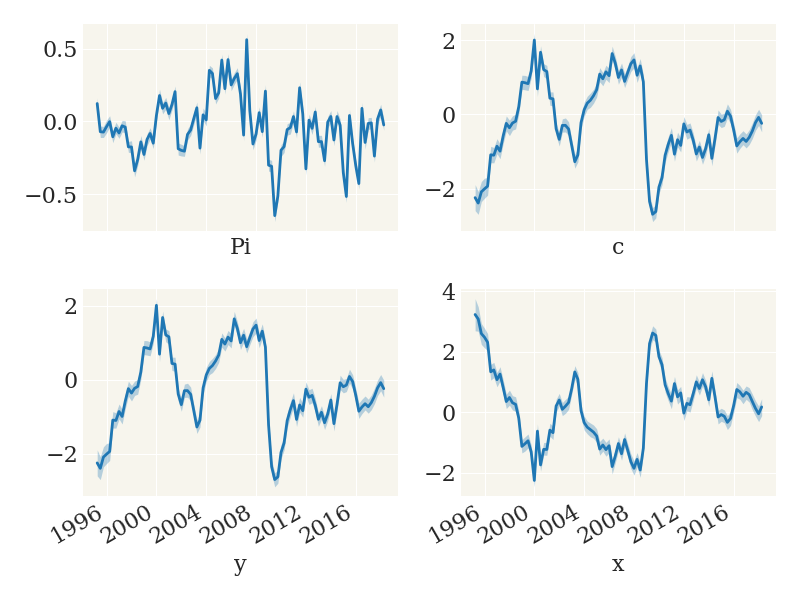

<IPython.core.display.Javascript object>


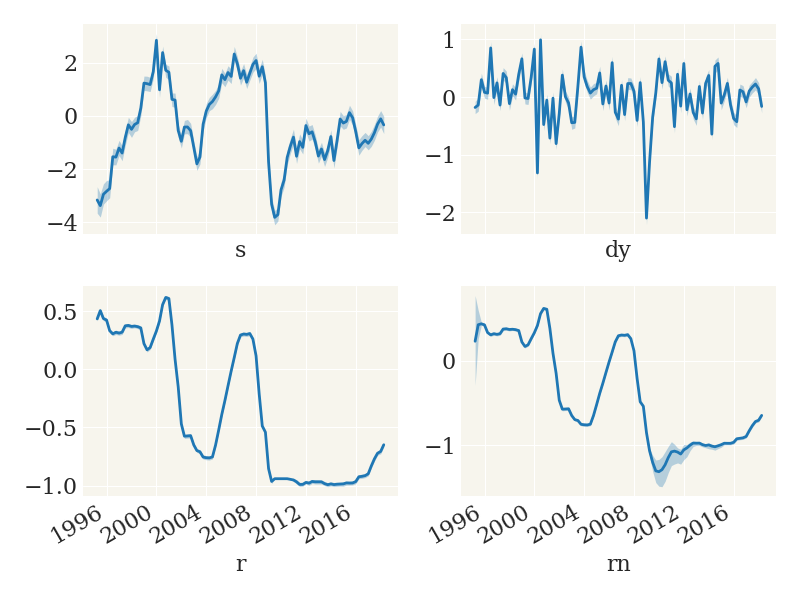

<IPython.core.display.Javascript object>


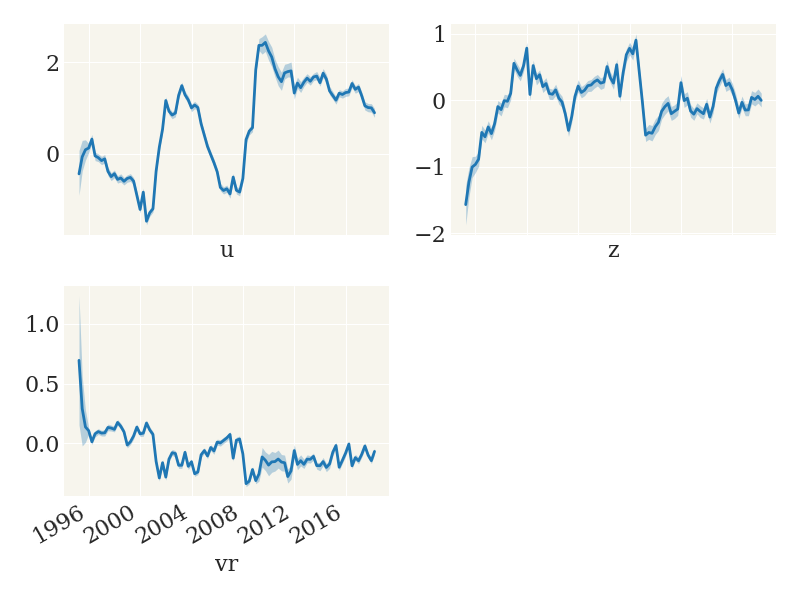

In [19]:
figs, axs = pplot(FX, mod.data.index, labels=mod.vv)

We can also have a look at the implied observables. The function ``mod.obs()``
is the observation function, implemented to work on particle clouds (such as ``FX``):


<IPython.core.display.Javascript object>


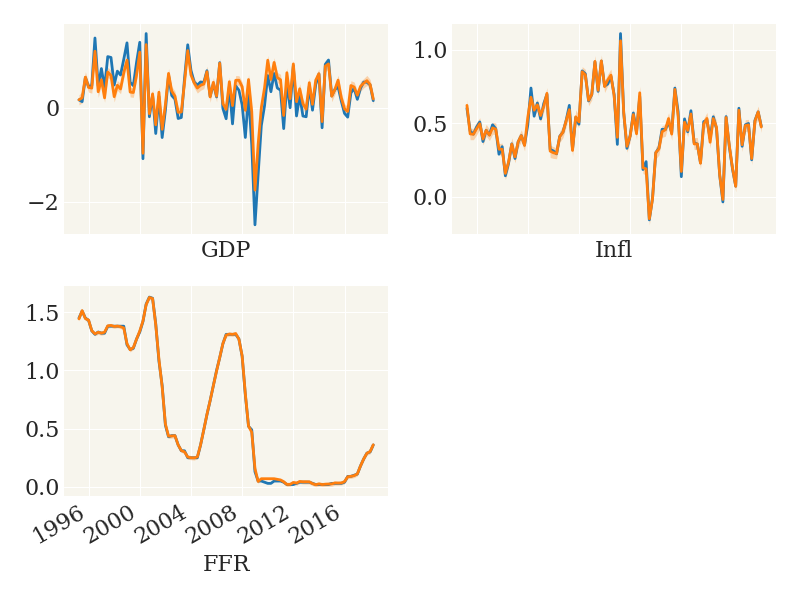

In [20]:
FZ = mod.obs(FX)
figs, axs = pplot((mod.Z, FZ), mod.data.index, labels=mod.observables)

Note that these particles/ensemble members/"dots" yet do not *fully* obey the nonlinearity of the transition function but contain approximation errors. To get rid of those we need adjustment smoothing.

### Adjustment smoothing

[TBD]


### Simulating counterfactuals
--------------------------

[TBD]


## Processing estimation results
-----------------------------

[TBD]

[TODO: set non-standard paths]

[TODO: obtain estimation stats]

[TODO: irfs with postrior draws]

[TODO: filter with postrior draws]

[TODO: counterfactuals with postrior draws]

[TODO: document at all funcs in DSGE module]
